# Convex curve constraint

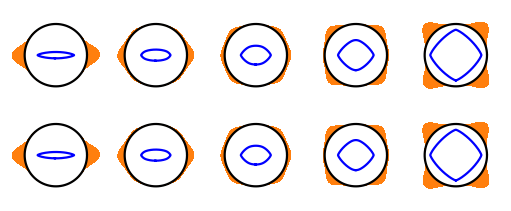

In [22]:
# =======================
# Constrained vs Unconstrained on S¹
# Fig 1: Curves (2×5)
# Fig 2: Density standing on the circle (2×5) with ORANGE band + BLACK support circle
# =======================

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')  # adjust if your `proximal/` lives elsewhere
from proximal.dynamicUOT import computeGeodesic

# ---------- helpers -----------------------------------------------------------
def wrap(x):                     # map any real angle to (–π,π]
    return (x + np.pi) % (2*np.pi) - np.pi

def gaussian_on_circle(t, mu, sigma):
    return np.exp(-0.5 * wrap(t - mu)**2 / sigma**2)

def rho_two_bumps(theta, mu=0.0, sigma=0.25):
    g1  = gaussian_on_circle(theta,        mu, sigma)
    g2  = gaussian_on_circle(theta, mu+np.pi, sigma)
    return g1 + g2

def normalize_density(rho, desired_mass=1.0):
    dx = 2*np.pi / rho.size
    return rho / (rho.sum() * dx) * desired_mass

def make_HF(theta, T):
    H = [np.tile(np.cos(theta), (T, 1)),   # (T, K)
         np.tile(np.sin(theta), (T, 1))]
    F = [np.zeros(T), np.zeros(T)]
    return H, F

def reconstruct_curve(rho, theta):
    """Turn a direction-measure on S¹ into a closed polyline in R²."""
    dtheta = theta[1] - theta[0]
    seglen = rho * dtheta
    step   = np.column_stack((seglen*np.cos(theta),
                              seglen*np.sin(theta)))
    V = np.concatenate([[(0.0, 0.0)], np.cumsum(step, axis=0)])  # (K+1,2)
    V[-1] = V[0]                       # enforce closure
    V -= V.mean(axis=0)                # center for plotting
    return V

def compute_geodesic_series(rho_0, rho_1, T, ll, opts, H=None, F=None, periodic=True):
    """Run computeGeodesic and return (rho_series, curves, theta)."""
    if (H is None) and (F is None):
        x, _ = computeGeodesic(rho_0, rho_1, T, ll, periodic=periodic, **opts)
    else:
        x, _ = computeGeodesic(rho_0, rho_1, T, ll, H=H, F=F, periodic=periodic, **opts)
    rho_series = x.V.D[0]                          # (T, K)
    K = rho_series.shape[1]
    theta = np.linspace(0.0, 2*np.pi, K, endpoint=False)
    curves = [reconstruct_curve(rho_series[t], theta) for t in range(T)]
    return rho_series, curves, theta

def common_curve_bounds(*curve_lists):
    r = 0.0
    for L in curve_lists:
        for V in L:
            r = max(r, np.linalg.norm(V, axis=1).max())
    m = 0.05 * r
    return (-r - m, r + m), (-r - m, r + m)

# Seam-free density band (orange) standing on circle + BLACK support circle
def plot_density_on_circle(ax, theta, rho_scaled,
                           height=0.40, base_radius=1.0,
                           fill_color='tab:orange', face_alpha=1.0,
                           draw_support_circle=True, support_lw=1.6,
                           seam_shift=True):
    """
    Draw a single closed polygon to avoid a seam at θ=0.
    `rho_scaled` should be normalized by a global max (so it’s in [0,1]).
    Adds a BLACK unit circle as the support.
    """
    dth = theta[1] - theta[0]
    th  = theta + (0.5 * dth if seam_shift else 0.0)

    # Baseline & raised rim
    xb = base_radius * np.cos(th); yb = base_radius * np.sin(th)
    xr = (base_radius + height * rho_scaled) * np.cos(th)
    yr = (base_radius + height * rho_scaled) * np.sin(th)

    # Explicit closure
    xb = np.r_[xb, xb[0]]; yb = np.r_[yb, yb[0]]
    xr = np.r_[xr, xr[0]]; yr = np.r_[yr, yr[0]]

    # One closed polygon: rim forward + baseline backward (no edge -> no seam)
    xpoly = np.r_[xr, xb[::-1]]
    ypoly = np.r_[yr, yb[::-1]]
    ax.fill(xpoly, ypoly, color=fill_color, alpha=face_alpha,
            linewidth=0, edgecolor='none', antialiased=False, zorder=1)

    # Black support circle on TOP of fill (crisp outline of support)
    if draw_support_circle:
        ax.plot(xb, yb, lw=support_lw, color="k",
                solid_capstyle="round", solid_joinstyle="round", zorder=2)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

# ---------- problem setup -----------------------------------------------------
sigma = 0.2
T = 15
K = 256
ll = (1.0, 1.0)
theta_grid = np.linspace(0.0, 2*np.pi, K, endpoint=False)

rho_0 = rho_two_bumps(theta_grid, mu=0.0, sigma=sigma)
rho_1 = (gaussian_on_circle(theta_grid, mu=np.pi/4,   sigma=sigma)
       + gaussian_on_circle(theta_grid, mu=3*np.pi/4, sigma=sigma)
       + gaussian_on_circle(theta_grid, mu=5*np.pi/4, sigma=sigma)
       + gaussian_on_circle(theta_grid, mu=7*np.pi/4, sigma=sigma))

rho_0 = normalize_density(rho_0, desired_mass=1.0)
rho_1 = normalize_density(rho_1, desired_mass=2.0)

solver_opts = dict(p=2.0, q=2.0, delta=0.01, niter=3000, big_matrix=True)

# Constrained
H, F = make_HF(theta_grid, T)
rho_constr, curves_constr, theta = compute_geodesic_series(
    rho_0, rho_1, T, ll, solver_opts, H=H, F=F, periodic=True
)

# Unconstrained
rho_free, curves_free, _ = compute_geodesic_series(
    rho_0, rho_1, T, ll, solver_opts, periodic=True
)

# Time slices: t ≈ 0, .25, .5, .75, 1.0
taus = [0.00, 0.25, 0.50, 0.75, 1.00]
idxs = [min(T-1, max(0, int(round(tau*(T-1))))) for tau in taus]
# ---------- NEW: Density-first figures with curve insets ---------------------
def add_density_with_curve(ax, theta, rho_t, V_t,
                           max_rho_global, xlim_curve, ylim_curve,
                           height=0.40, base_radius=1.0,
                           inset_loc=[0.60, 0.05, 0.35, 0.35]):  # [x0,y0,w,h] in axes fraction
    """
    Draw the density-on-circle on `ax`, then add a small inset with the curve.
    - inset_loc is in Axes coordinates (fractions of the main axes box).
    """
    # Primary: density band standing on the circle
    plot_density_on_circle(ax, theta, rho_t / max_rho_global,
                           height=height, base_radius=base_radius,
                           fill_color='tab:orange', face_alpha=1.0,
                           draw_support_circle=True, support_lw=1.6,
                           seam_shift=True)
    # Keep same limits as before for consistent framing of the density
    rmax = base_radius + height
    m = 0.05 * rmax
    ax.set_xlim((-rmax - m, rmax + m))
    ax.set_ylim((-rmax - m, rmax + m))

    # Secondary: curve inset (uses global curve bounds)
    iax = ax.inset_axes(inset_loc)  # x0, y0, w, h in axes fraction
    iax.plot(V_t[:, 0], V_t[:, 1], lw=1.6, color='k')
    iax.set_aspect("equal", adjustable="box")
    iax.set_xlim(xlim_curve); iax.set_ylim(ylim_curve)
    iax.set_xticks([]); iax.set_yticks([])
    for s in iax.spines.values():
        s.set_visible(True)
        s.set_linewidth(1.0)
        s.set_color('0.2')
    iax.set_facecolor('white')
    iax.patch.set_alpha(0.9)  # subtle backdrop so the inset reads well


# Shared limits: curves & densities
max_rho_global = max(rho_constr.max(), rho_free.max())
xlim_curve, ylim_curve = common_curve_bounds(curves_constr, curves_free)

# ---------- NEW: single 2×5 figure; densities primary; curve inside circle ----
def max_curve_radius(*curve_lists):
    r = 0.0
    for L in curve_lists:
        for V in L:
            r = max(r, np.linalg.norm(V, axis=1).max())
    return r

max_rho_global = max(rho_constr.max(), rho_free.max())
height = 0.40
rmax = 1.0 + height  # outer rim of density band
m = 0.05 * rmax
xlim2 = (-rmax - m, rmax + m)
ylim2 = (-rmax - m, rmax + m)

# scale all curves to live strictly inside the unit circle (no overlap)
r_curves = max_curve_radius(curves_constr, curves_free)
curve_radius_inside = 0.82   # fraction of unit circle; tweak (e.g., 0.75–0.9)
scale = (curve_radius_inside / r_curves) if r_curves > 0 else 1.0

fig, axes = plt.subplots(2, 5, figsize=(5, 2), constrained_layout=True)

for row_idx, (rho_series, curves_series) in enumerate([(rho_constr, curves_constr),
                                                       (rho_free,   curves_free)]):
    for col, idx in enumerate(idxs):
        ax = axes[row_idx, col]

        # primary: density band on the circle
        plot_density_on_circle(ax, theta, rho_series[idx] / max_rho_global,
                               height=height, base_radius=1.0,
                               fill_color='tab:orange', face_alpha=1.0,
                               draw_support_circle=True, support_lw=1.6,
                               seam_shift=True)
        ax.set_xlim(xlim2); ax.set_ylim(ylim2)

        # secondary: curve drawn INSIDE the unit circle (same axes, scaled)
        V = curves_series[idx] * scale
        ax.plot(V[:, 0], V[:, 1], lw=1.6, color='b', zorder=3)

        # no titles, no ticks/spines (plot_density_on_circle already cleans them)

# Optional save:
fig.savefig("figures/fig_density_with_inner_curves_constrained_vs_unconstrained.png",
            dpi=300, bbox_inches="tight")
plt.show()


In [25]:
# ---------- L2 distances between constrained and unconstrained densities -------
# Space L2 at each time:  ||ρ_c(t,·) - ρ_u(t,·)||_{L2(S^1)} = sqrt(∫ (Δρ)^2 dθ)
K_grid = rho_constr.shape[1]
T_time = rho_constr.shape[0]
dtheta = 2*np.pi / K_grid
dt     = ll[0] / T_time  # if ll[0] is total time length (e.g., 1.0)

diff = rho_constr - rho_free                         # shape (T, K)
l2_by_time = np.sqrt((diff**2).sum(axis=1) * dtheta) # shape (T,)

# Report the five requested times
print("L2(ρ_constrained, ρ_unconstrained) on S¹ at requested times:")
for tau, idx in zip(taus, idxs):
    print(f"  t ≈ {tau:4.2f} (index {idx:02d}): {l2_by_time[idx]:.6e}")

# Optional summaries:
# Space–time L2 over [0,ll[0]]×S¹: sqrt(∫_0^{ll[0]} ∫ (Δρ)^2 dθ dt)
l2_spacetime = np.sqrt(np.sum(l2_by_time**2) * dt)
# RMS over time of the spatial L2 (units: same as density * sqrt(length))
l2_time_rms  = l2_spacetime / np.sqrt(ll[0])

print(f"\nSpace–time L2 over [0,{ll[0]}]×S¹: {l2_spacetime:.6e}")
print(f"RMS-in-time of spatial L2:        {l2_time_rms:.6e}")


L2(ρ_constrained, ρ_unconstrained) on S¹ at requested times:
  t ≈ 0.00 (index 00): 1.564773e-08
  t ≈ 0.25 (index 04): 7.599783e-08
  t ≈ 0.50 (index 07): 1.321688e-07
  t ≈ 0.75 (index 10): 8.215532e-08
  t ≈ 1.00 (index 14): 1.902587e-08

Space–time L2 over [0,1.0]×S¹: 8.734339e-08
RMS-in-time of spatial L2:        8.734339e-08


# Nonsymmetric case

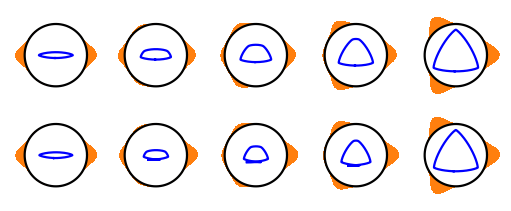

In [23]:
# =======================
# Constrained vs Unconstrained on S¹
# Fig 1: Curves (2×5)
# Fig 2: Density standing on the circle (2×5) with ORANGE band + BLACK support circle
# =======================

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')  # adjust if your `proximal/` lives elsewhere
from proximal.dynamicUOT import computeGeodesic

# ---------- helpers -----------------------------------------------------------
def wrap(x):                     # map any real angle to (–π,π]
    return (x + np.pi) % (2*np.pi) - np.pi

def gaussian_on_circle(t, mu, sigma):
    return np.exp(-0.5 * wrap(t - mu)**2 / sigma**2)

def rho_two_bumps(theta, mu=0.0, sigma=0.25):
    g1  = gaussian_on_circle(theta,        mu, sigma)
    g2  = gaussian_on_circle(theta, mu+np.pi, sigma)
    return g1 + g2

def normalize_density(rho, desired_mass=1.0):
    dx = 2*np.pi / rho.size
    return rho / (rho.sum() * dx) * desired_mass

def make_HF(theta, T):
    H = [np.tile(np.cos(theta), (T, 1)),   # (T, K)
         np.tile(np.sin(theta), (T, 1))]
    F = [np.zeros(T), np.zeros(T)]
    return H, F

def reconstruct_curve(rho, theta):
    """Turn a direction-measure on S¹ into a closed polyline in R²."""
    dtheta = theta[1] - theta[0]
    seglen = rho * dtheta
    step   = np.column_stack((seglen*np.cos(theta),
                              seglen*np.sin(theta)))
    V = np.concatenate([[(0.0, 0.0)], np.cumsum(step, axis=0)])  # (K+1,2)
    V[-1] = V[0]                       # enforce closure
    V -= V.mean(axis=0)                # center for plotting
    return V

def compute_geodesic_series(rho_0, rho_1, T, ll, opts, H=None, F=None, periodic=True):
    """Run computeGeodesic and return (rho_series, curves, theta)."""
    if (H is None) and (F is None):
        x, _ = computeGeodesic(rho_0, rho_1, T, ll, periodic=periodic, **opts)
    else:
        x, _ = computeGeodesic(rho_0, rho_1, T, ll, H=H, F=F, periodic=periodic, **opts)
    rho_series = x.V.D[0]                          # (T, K)
    K = rho_series.shape[1]
    theta = np.linspace(0.0, 2*np.pi, K, endpoint=False)
    curves = [reconstruct_curve(rho_series[t], theta) for t in range(T)]
    return rho_series, curves, theta

def common_curve_bounds(*curve_lists):
    r = 0.0
    for L in curve_lists:
        for V in L:
            r = max(r, np.linalg.norm(V, axis=1).max())
    m = 0.05 * r
    return (-r - m, r + m), (-r - m, r + m)

# Seam-free density band (orange) standing on circle + BLACK support circle
def plot_density_on_circle(ax, theta, rho_scaled,
                           height=0.40, base_radius=1.0,
                           fill_color='tab:orange', face_alpha=1.0,
                           draw_support_circle=True, support_lw=1.6,
                           seam_shift=True):
    """
    Draw a single closed polygon to avoid a seam at θ=0.
    `rho_scaled` should be normalized by a global max (so it’s in [0,1]).
    Adds a BLACK unit circle as the support.
    """
    dth = theta[1] - theta[0]
    th  = theta + (0.5 * dth if seam_shift else 0.0)

    # Baseline & raised rim
    xb = base_radius * np.cos(th); yb = base_radius * np.sin(th)
    xr = (base_radius + height * rho_scaled) * np.cos(th)
    yr = (base_radius + height * rho_scaled) * np.sin(th)

    # Explicit closure
    xb = np.r_[xb, xb[0]]; yb = np.r_[yb, yb[0]]
    xr = np.r_[xr, xr[0]]; yr = np.r_[yr, yr[0]]

    # One closed polygon: rim forward + baseline backward (no edge -> no seam)
    xpoly = np.r_[xr, xb[::-1]]
    ypoly = np.r_[yr, yb[::-1]]
    ax.fill(xpoly, ypoly, color=fill_color, alpha=face_alpha,
            linewidth=0, edgecolor='none', antialiased=False, zorder=1)

    # Black support circle on TOP of fill (crisp outline of support)
    if draw_support_circle:
        ax.plot(xb, yb, lw=support_lw, color="k",
                solid_capstyle="round", solid_joinstyle="round", zorder=2)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

# ---------- problem setup -----------------------------------------------------
sigma = 0.2
T = 15
K = 256
ll = (1.0, 1.0)
theta_grid = np.linspace(0.0, 2*np.pi, K, endpoint=False)

rho_0 = rho_two_bumps(theta_grid, mu=0.0, sigma=sigma)
rho_1 = (gaussian_on_circle(theta_grid, mu=0,   sigma=sigma)
         + gaussian_on_circle(theta_grid, mu=2 * np.pi/3,   sigma=sigma)
         + gaussian_on_circle(theta_grid, mu=4 * np.pi/3, sigma=sigma))

rho_0 = normalize_density(rho_0, desired_mass=1.0)
rho_1 = normalize_density(rho_1, desired_mass=2.0)

solver_opts = dict(p=2.0, q=2.0, delta=0.01, niter=3000, big_matrix=True)

# Constrained
H, F = make_HF(theta_grid, T)
rho_constr, curves_constr, theta = compute_geodesic_series(
    rho_0, rho_1, T, ll, solver_opts, H=H, F=F, periodic=True
)

# Unconstrained
rho_free, curves_free, _ = compute_geodesic_series(
    rho_0, rho_1, T, ll, solver_opts, periodic=True
)

# Time slices: t ≈ 0, .25, .5, .75, 1.0
taus = [0.00, 0.25, 0.50, 0.75, 1.00]
idxs = [min(T-1, max(0, int(round(tau*(T-1))))) for tau in taus]
# ---------- FIGURE 2: Density on the circle (orange band + BLACK support) ----
# ---------- NEW: Density-first figures with curve insets ---------------------
def add_density_with_curve(ax, theta, rho_t, V_t,
                           max_rho_global, xlim_curve, ylim_curve,
                           height=0.40, base_radius=1.0,
                           inset_loc=[0.60, 0.05, 0.35, 0.35]):  # [x0,y0,w,h] in axes fraction
    """
    Draw the density-on-circle on `ax`, then add a small inset with the curve.
    - inset_loc is in Axes coordinates (fractions of the main axes box).
    """
    # Primary: density band standing on the circle
    plot_density_on_circle(ax, theta, rho_t / max_rho_global,
                           height=height, base_radius=base_radius,
                           fill_color='tab:orange', face_alpha=1.0,
                           draw_support_circle=True, support_lw=1.6,
                           seam_shift=True)
    # Keep same limits as before for consistent framing of the density
    rmax = base_radius + height
    m = 0.05 * rmax
    ax.set_xlim((-rmax - m, rmax + m))
    ax.set_ylim((-rmax - m, rmax + m))

    # Secondary: curve inset (uses global curve bounds)
    iax = ax.inset_axes(inset_loc)  # x0, y0, w, h in axes fraction
    iax.plot(V_t[:, 0], V_t[:, 1], lw=1.6, color='k')
    iax.set_aspect("equal", adjustable="box")
    iax.set_xlim(xlim_curve); iax.set_ylim(ylim_curve)
    iax.set_xticks([]); iax.set_yticks([])
    for s in iax.spines.values():
        s.set_visible(True)
        s.set_linewidth(1.0)
        s.set_color('0.2')
    iax.set_facecolor('white')
    iax.patch.set_alpha(0.9)  # subtle backdrop so the inset reads well


# Shared limits: curves & densities
max_rho_global = max(rho_constr.max(), rho_free.max())
xlim_curve, ylim_curve = common_curve_bounds(curves_constr, curves_free)

# ---------- NEW: single 2×5 figure; densities primary; curve inside circle ----
def max_curve_radius(*curve_lists):
    r = 0.0
    for L in curve_lists:
        for V in L:
            r = max(r, np.linalg.norm(V, axis=1).max())
    return r

max_rho_global = max(rho_constr.max(), rho_free.max())
height = 0.40
rmax = 1.0 + height  # outer rim of density band
m = 0.05 * rmax
xlim2 = (-rmax - m, rmax + m)
ylim2 = (-rmax - m, rmax + m)

# scale all curves to live strictly inside the unit circle (no overlap)
r_curves = max_curve_radius(curves_constr, curves_free)
curve_radius_inside = 0.82   # fraction of unit circle; tweak (e.g., 0.75–0.9)
scale = (curve_radius_inside / r_curves) if r_curves > 0 else 1.0

fig, axes = plt.subplots(2, 5, figsize=(5, 2), constrained_layout=True)

for row_idx, (rho_series, curves_series) in enumerate([(rho_constr, curves_constr),
                                                       (rho_free,   curves_free)]):
    for col, idx in enumerate(idxs):
        ax = axes[row_idx, col]

        # primary: density band on the circle
        plot_density_on_circle(ax, theta, rho_series[idx] / max_rho_global,
                               height=height, base_radius=1.0,
                               fill_color='tab:orange', face_alpha=1.0,
                               draw_support_circle=True, support_lw=1.6,
                               seam_shift=True)
        ax.set_xlim(xlim2); ax.set_ylim(ylim2)

        # secondary: curve drawn INSIDE the unit circle (same axes, scaled)
        V = curves_series[idx] * scale
        ax.plot(V[:, 0], V[:, 1], lw=1.6, color='b', zorder=3)

        # no titles, no ticks/spines (plot_density_on_circle already cleans them)

# Optional save:
fig.savefig("figures/fig_unsym_density_with_inner_curves_constrained_vs_unconstrained.png",
            dpi=300, bbox_inches="tight")
plt.show()


In [4]:
# ---------- L2 distances between constrained and unconstrained densities -------
# Space L2 at each time:  ||ρ_c(t,·) - ρ_u(t,·)||_{L2(S^1)} = sqrt(∫ (Δρ)^2 dθ)
K_grid = rho_constr.shape[1]
T_time = rho_constr.shape[0]
dtheta = 2*np.pi / K_grid
dt     = ll[0] / T_time  # if ll[0] is total time length (e.g., 1.0)

diff = rho_constr - rho_free                         # shape (T, K)
l2_by_time = np.sqrt((diff**2).sum(axis=1) * dtheta) # shape (T,)

# Report the five requested times
print("L2(ρ_constrained, ρ_unconstrained) on S¹ at requested times:")
for tau, idx in zip(taus, idxs):
    print(f"  t ≈ {tau:4.2f} (index {idx:02d}): {l2_by_time[idx]:.6e}")

# Optional summaries:
# Space–time L2 over [0,ll[0]]×S¹: sqrt(∫_0^{ll[0]} ∫ (Δρ)^2 dθ dt)
l2_spacetime = np.sqrt(np.sum(l2_by_time**2) * dt)
# RMS over time of the spatial L2 (units: same as density * sqrt(length))
l2_time_rms  = l2_spacetime / np.sqrt(ll[0])

print(f"\nSpace–time L2 over [0,{ll[0]}]×S¹: {l2_spacetime:.6e}")
print(f"RMS-in-time of spatial L2:        {l2_time_rms:.6e}")


L2(ρ_constrained, ρ_unconstrained) on S¹ at requested times:
  t ≈ 0.00 (index 00): 2.308027e-02
  t ≈ 0.25 (index 04): 1.553691e-01
  t ≈ 0.50 (index 07): 1.865657e-01
  t ≈ 0.75 (index 10): 1.626349e-01
  t ≈ 1.00 (index 14): 2.531132e-02

Space–time L2 over [0,1.0]×S¹: 1.377963e-01
RMS-in-time of spatial L2:        1.377963e-01
